# Time series data in python

In this workshop we will be exploring time series analysis in python, specifically how we can prepare our data for modelling, which we will do in the next workshop.

The data we will be using comes from an Ecuadorian chain of department stores. Each row represents the total sales a store made in a particular department on a given day, and whether there was a promotion on or not. To reduce the size of the dataset, it has been filtered to only show one store. 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

sales=pd.read_csv('store_sales.csv')

# For time series data to work it needs to be in a datetime format
# The following line converts the data type as well as puts it in a UK format
sales['Date']=pd.to_datetime(sales.Date, dayfirst=True, format="%d/%m/%Y") 
sales_index=sales.copy()
sales_index.set_index('Date',inplace=True)
sales_index.head()

,family,sales,onpromotion
Date,,,
2013-01-01,AUTOMOTIVE,0.0,0
2013-01-01,BABY CARE,0.0,0
2013-01-01,BEAUTY,0.0,0
2013-01-01,BEVERAGES,0.0,0
2013-01-01,BOOKS,0.0,0


## Stationarity

Like with the machine learning models we met in the last module, time series models require EDA and data cleaning. Some of the techniques are the same, but in this workshop we will explore those specific for time series analysis. 

One such area is the concept of stationarity. An assumption for many time series models (like AutoRegressive models) is that the data must be stationary, this means that the mean, variance and autocorrelation do not change over time. If your data has a clear trend, then it is likely the data is not stationary.

In this next section we will see how to examine our time series data to check for stationarity, and what we can do if it is violated. 

Note, not all forecasting models require the data to be stationary, but it is still useful to check so as to give us the maximum number of options when selecting a model.

### Viewing the data

The first step in examining time series data is to view it by plotting a line graph. This allows us to visually inspect the trend and any seasonality that might be present.

Any visualisation showing time series must have the 'time' as the independent variable (on the x-axis). 

For this demonstration we are going to group the data by day to combine sales from across all departments.

In [2]:
# Create a dataframe that aggregates all sales for each day

total_sales=sales_index.resample('d').sum()
total_sales.head()

,sales,onpromotion
Date,,
2013-01-01,0.000000,0
2013-01-02,7417.148000,0
2013-01-03,5873.244001,0
2013-01-04,5919.879001,0
2013-01-05,6318.785010,0


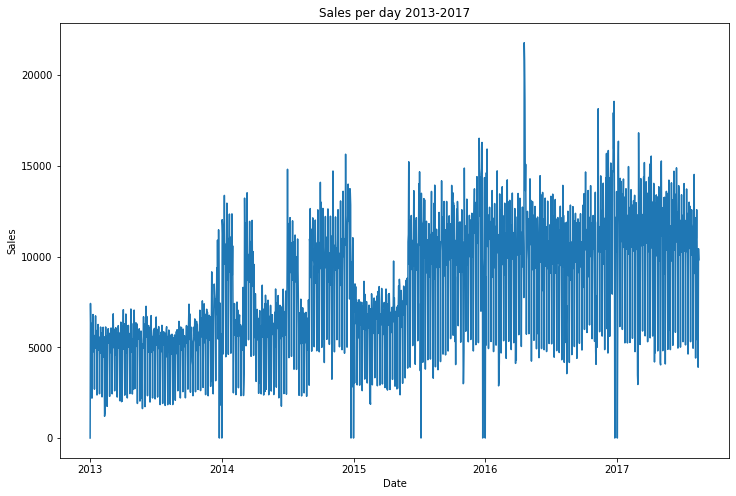

In [3]:
# plot time series line graph

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8)) # this line sets the size of the visualisation
ax.plot(total_sales.index,total_sales.sales) # this plots the data
ax.set_title('Sales per day 2013-2017')
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
plt.show()

How informative is this chart?

Not very. Aggregating our data by data gives us too many data points and is sensitive to extreme one-off changes (like being shut at Christmas). 

Let's try aggregating the data over longer periods to help us observe trends:

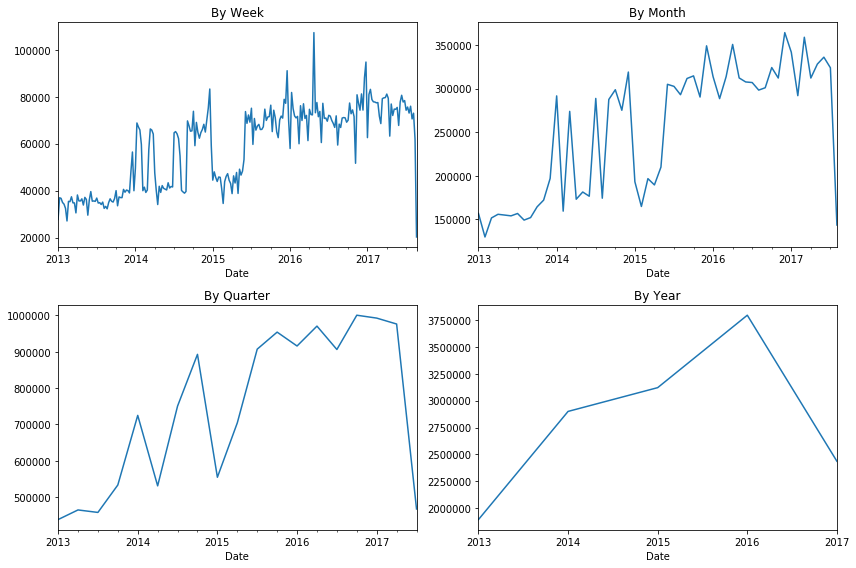

In [4]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(12,8))
total_sales.sales.resample('w').sum().plot(ax=ax[0,0]) # group by week
total_sales.sales.resample('m').sum().plot(ax=ax[0,1]) # group by month
total_sales.sales.resample('q').sum().plot(ax=ax[1,0]) # group by quarter
total_sales.sales.resample('a').sum().plot(ax=ax[1,1]) # group by year
ax[0,0].set_title('By Week')
ax[0,1].set_title('By Month')
ax[1,0].set_title('By Quarter')
ax[1,1].set_title('By Year')
fig.tight_layout()
plt.show()

By resampling the data we get a clearer idea of what trend is happening within our data. It appears that the sales have been trending upwards (which is good for the store). However, as there is a clear upwards trend, the mean over time will be increasing which means the data is not stationary. For some models this will not be a problem, but for others it will. 

To view what the overall trend is, we can plot a trendline over the data.

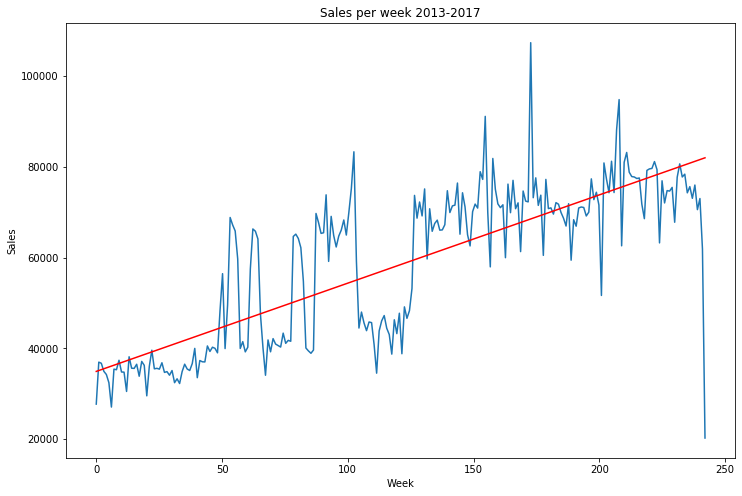

In [5]:
sales_by_week=total_sales.resample('w').sum() # create dataframe which shows sales by week

data_points=np.linspace(0,len(sales_by_week),num=len(sales_by_week)) # Creates list of data points as long as dataframe

line_coef = np.polyfit(data_points,sales_by_week.sales,1) # Finds the trendline of the weekly sales data

polynomial = np.poly1d(line_coef) # Function that for any independent variable given, will return the dependent variable

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data_points,sales_by_week.sales)
ax.plot(data_points, polynomial(data_points),c='red')
ax.set_title('Sales per week 2013-2017')
ax.set_ylabel('Sales')
ax.set_xlabel('Week')
plt.show()

Do trends have to be linear?

Not always, sometimes they may curve exponentially. The process of plotting a trend line is flexible enough to allow for 'higher-order' trends (those which curve).

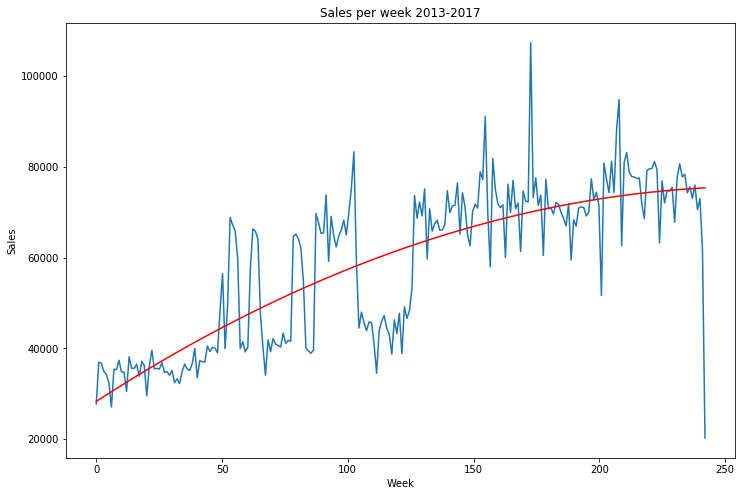

In [6]:
data_points=np.linspace(0,len(sales_by_week),num=len(sales_by_week)) 
line_coef = np.polyfit(data_points,sales_by_week.sales,2) # Find trendline of polynomil degree 2 (curve)
polynomial = np.poly1d(line_coef) 

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data_points,sales_by_week.sales)
ax.plot(data_points, polynomial(data_points),c='red')
ax.set_title('Sales per week 2013-2017')
ax.set_ylabel('Sales')
ax.set_xlabel('Week')
plt.show()

It is clear then that the data is not stationary and is trending upwards. Another way we can check for stationarity is to perform an <b>Augmented Dickey-Fuller</b> test which has the following hypothesis:

<ul>
    <li><b>Null Hypothesis</b>- The data is not stationary </li>
    <li><b>Alternate Hypothesis</b>- The data is stationary </li>
</ul>

Test at the 5% level.

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_by_week.sales)
print('p-value: ' +str(result[1]))

p-value: 0.31488664700865104


The p-value is greater than 0.05, so we fail to reject the null hypothesis and conclude the data is not stationary.

So far we have identified trends visually, but this has been using the data in a raw form (although aggregated). This means that our method of identifying trends is vulnerable to outliers or extreme changes between observations. The following techniques allow us to 'smooth' out trends so we can more easily identify what they are.

### Rolling 

A useful investigation within our data for identifying trend is to examine how a variable 'rolls' over time. The technique involves grouping a given number (e.g. 3) observations together and calculating an aggregate (e.g. mean). We then move the process forward one observation and calculate the aggregate again.

To give an example, in a week our first 'window' would be Monday, Tuesday and Wednesday. The second 'window' would be Tuesday, Wednesday and Thursday. The third would be Wednesday, Thursday and Friday and so on. 

Rolling values allow us to see how the data is behaving through moving windows, and can be far more informative than looking at the raw data. Looking at each data point individually is risky, as this allows for daily anomalies to have a large effect. Instead, by grouping dates together we can more easily ignore outliers and see what the overall trend is. For example, during parts of the year where you would expect higher sales (e.g. Christmas) it is useful to see how sales are performing over a group of days, which can then be compared to each other. 

To calculate rolling statistics we need to supply two inputs- 

<ul>
    <li><b>window</b> - how many observations to include </li>
    <li><b>center</b> - set to True if you want the window to center on the date for that observation</li>
</ul>

<table>
    <tr>
        <th> <code> center = True </code></th>
        <th> <code> center = False </code></th>
    </tr>
    <tr>
        <td> Monday, <b> Tuesday </b>, Wednesday </td>
        <td> Monday, Tuesday, <b> Wednesday </b> </td>
    </tr>
</table>

In [8]:
# calculate the rolling average over 5 days

total_sales.rolling(window=5, center=True).mean().head()

,sales,onpromotion
Date,,
2013-01-01,NaN,NaN
2013-01-02,NaN,NaN
2013-01-03,5105.811202,0.0
2013-01-04,5545.628602,0.0
2013-01-05,5292.383802,0.0


Notice how the first two points become nulls, why do you think this is?

In [9]:
# calculate the rolling average over 5 days with center set to False

total_sales.rolling(window=5, center=False).mean().head()

,sales,onpromotion
Date,,
2013-01-01,NaN,NaN
2013-01-02,NaN,NaN
2013-01-03,NaN,NaN
2013-01-04,NaN,NaN
2013-01-05,5105.811202,0.0


Let's plot the rolling window and compare to the raw data.

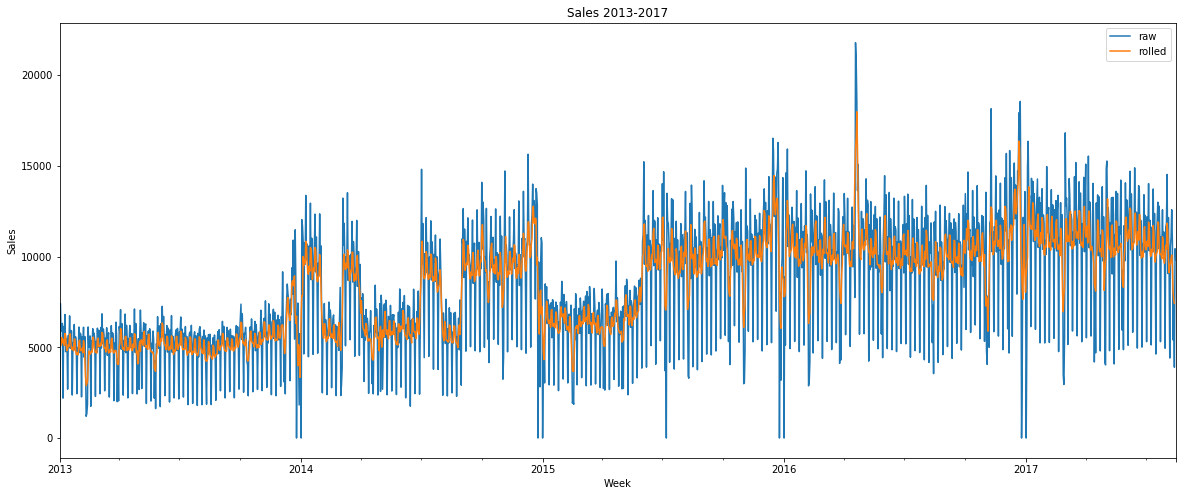

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
total_sales.sales.plot(ax=ax,label='raw')
total_sales.rolling(window=5, center= True).mean()['sales'].plot(ax=ax,label='rolled')
ax.set_title('Sales 2013-2017')
ax.set_ylabel('Sales')
ax.set_xlabel('Week')
plt.legend()
plt.show()

What do you spot has happened to the series trend when we have calculated rolling averages?

The trend has become smoother as the rolling process has removed daily variations making it easier to identify. You may also have spotted that outliers have also been accounted for, with their impact reduced. If your data contains outliers or has an obvious trend, rolling statistics is a method that can mitigate this.

Let's look at another couple of methods for investigating trends:

### Expanding mean

A rolling window aggregates data over a given period then moves along to give us a view of how data is changing. Expanding mean on the other hand calculates, for each observation, the mean up to that point (i.e. expanding, with each obsevation the calculation gets larger).

### Exponentially weighted

Similar to above, except it adds in a weighting to prioritse more recent observations. This method is less sensitive to extreme historical variations. You need to pass a parameter called `span` which tells the model how many observations should be included with each calculation.

The visualisation below compares all three methods:

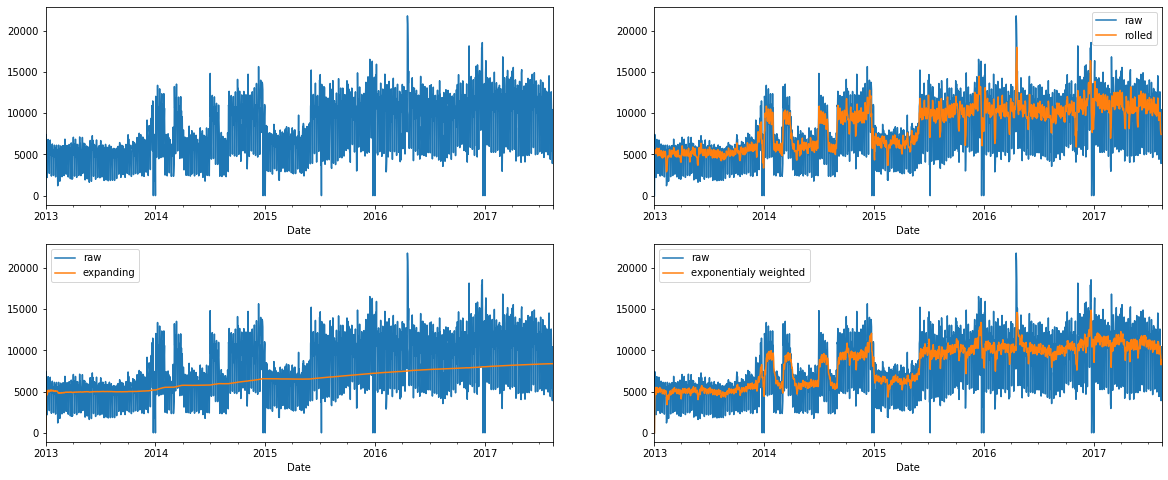

In [11]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,8))
total_sales.sales.plot(ax=ax[0,0],label='raw')
total_sales.sales.plot(ax=ax[0,1],label='raw')
total_sales.rolling(window=5, center= True).mean()['sales'].plot(ax=ax[0,1],label='rolled')
total_sales.sales.plot(ax=ax[1,0],label='raw')
total_sales.expanding().mean()['sales'].plot(ax=ax[1,0],label='expanding')
total_sales.sales.plot(ax=ax[1,1],label='raw')
total_sales.ewm(span=10).mean()['sales'].plot(ax=ax[1,1],label='exponentialy weighted')
ax[1,0].legend()
ax[1,1].legend()
ax[0,1].legend()
plt.show()

What similarities do you notice between them? What differences? 

Try playing around with the parameters (window for rolling, span for exponentially weighted) and see what happens.

## Practice

Create a new dataframe which groups the beverage sales by month, and then for your data calculate and plot a rolling average, expanding mean and exponentially weighted mean.

What trend do you observe? Does the techniques you have used help explain or remove the trend?

In [ ]:
#A:

Identifying trends in our data is useful analysis, as it allows us to observe what is going on and make rudimentary predictions about what might happen next. However, trends in our data makes our data non-stationary which can be a problem for some models. In the next section we will look at some techniques which we can use to 'smooth' out trends so that our data becomes stationary.

## Detrending

As previously mentioned, many time series models assume the data will be stationary, but in this case it clearly isn't. In this section we will explore a couple of methods we can use to remove the effect a trend is having on our data to help it become stationary.

Detrending means removing the effect a trend has on our time series data. For example, if we are observing that mean sales are increasing over time then there must be some formula which explains what that trend is. If we remove this from our data, we will be left with the underlying values (called residuals). Note, this is only required for specific models where staionarity is a condition (we will see these in the net workshop). Also, <b>you do not need to detrend data if there is no trend</b>, always inspect your data first to ensure this step is required.

There are several methods we can use to do this.

### Differencing

In this approach we simply transform our data to show the `difference in observations`. For example, instead of looking at total sales per day, we can examine the difference in sales per day. 

To save us calculating this manually, we can use the `.diff()` function which calculates the difference between consecutive observations.

In [13]:
total_sales['difference']=total_sales.sales.diff(periods = 1)

In [14]:
total_sales.head()

,sales,onpromotion,difference
Date,,,
2013-01-01,0.000000,0,NaN
2013-01-02,7417.148000,0,7417.148000
2013-01-03,5873.244001,0,-1543.903999
2013-01-04,5919.879001,0,46.635000
2013-01-05,6318.785010,0,398.906009


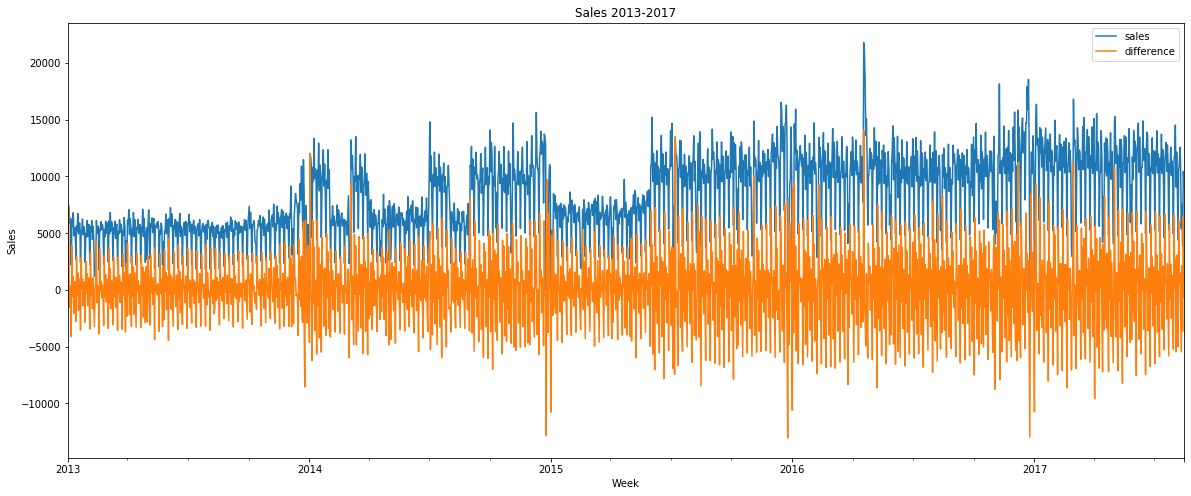

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
total_sales.sales.plot(ax=ax, label='sales')
total_sales.difference.plot(ax=ax,label='difference')
ax.set_title('Sales 2013-2017')
ax.set_ylabel('Sales')
ax.set_xlabel('Week')
plt.legend()
plt.show()

By calculating and plotting the differences in observations you can see that the effect of the trend has been removed from the data, making it stationary.

### Percentage change

Instead of looking at the absolute difference in observations, we can look at the <i>percentage</i> change. To do this we need to first calculate the difference in consecutive observations, and then convert this into a percentage.

The `.shift()` function will create a new dataframe which shifts all the data points by a specified number of places. We can use this to compare one observation with the next, and calculate the difference between them.

In [16]:
print('Original')
display(total_sales.head())
print('Shifted data')
display(total_sales.shift(1).head())

Original


,sales,onpromotion,difference
Date,,,
2013-01-01,0.000000,0,NaN
2013-01-02,7417.148000,0,7417.148000
2013-01-03,5873.244001,0,-1543.903999
2013-01-04,5919.879001,0,46.635000
2013-01-05,6318.785010,0,398.906009


Shifted data


,sales,onpromotion,difference
Date,,,
2013-01-01,NaN,NaN,NaN
2013-01-02,0.000000,0.0,NaN
2013-01-03,7417.148000,0.0,7417.148000
2013-01-04,5873.244001,0.0,-1543.903999
2013-01-05,5919.879001,0.0,46.635000


Each observation has now been shifted one place down. We can then create a calculation which returns the percentage change between observations:

In [17]:
total_sales['perc_diff']=((total_sales.sales-total_sales.shift(1).sales)/total_sales.shift(1).sales)*100
total_sales.head()

,sales,onpromotion,difference,perc_diff
Date,,,,
2013-01-01,0.000000,0,NaN,NaN
2013-01-02,7417.148000,0,7417.148000,inf
2013-01-03,5873.244001,0,-1543.903999,-20.815332
2013-01-04,5919.879001,0,46.635000,0.794025
2013-01-05,6318.785010,0,398.906009,6.738415


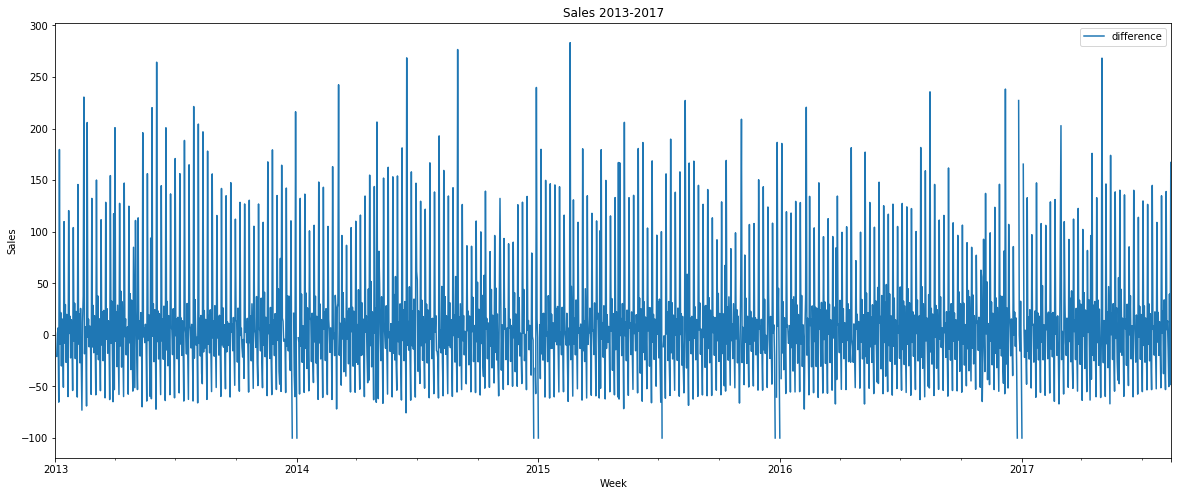

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
total_sales.perc_diff.plot(ax=ax,label='difference')
ax.set_title('Sales 2013-2017')
ax.set_ylabel('Sales')
ax.set_xlabel('Week')
plt.legend()
plt.show()

Due to the difference in scales we will not plot the original as a comparison, but you can see again how the trend has been removed from the data.

### Removing the effect of the trend

Another approach is to work out what the trend actually is and remove it from the data. This is done by calculating the trend line and for each observation, finding the difference between the trend and actual observation. This leaves what are called residual values, which should be stationary.

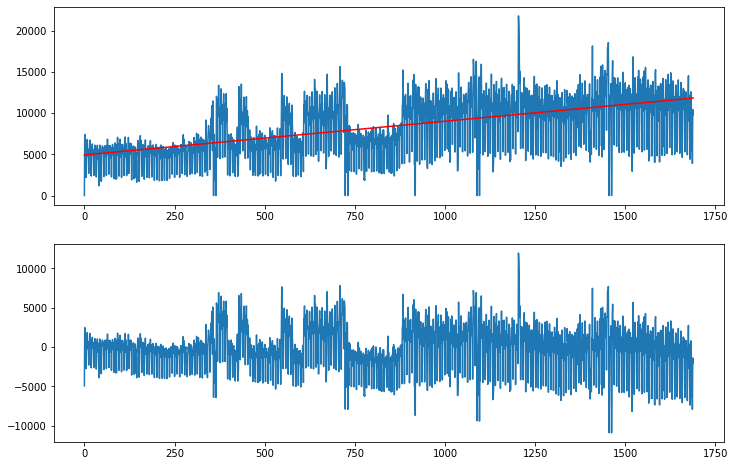

In [19]:
data_points=np.linspace(0,len(total_sales),num=len(total_sales))

line_coef = np.polyfit(data_points,total_sales.sales,1) 

polynomial = np.poly1d(line_coef) 

fig, ax = plt.subplots(nrows=2,figsize=(12,8))
ax[0].plot(data_points,total_sales.sales)
ax[0].plot(data_points, polynomial(data_points),c='red')
ax[1].plot(data_points, total_sales.sales - polynomial(data_points))
plt.show()

Fortunately there is a function that will perform this process for us.

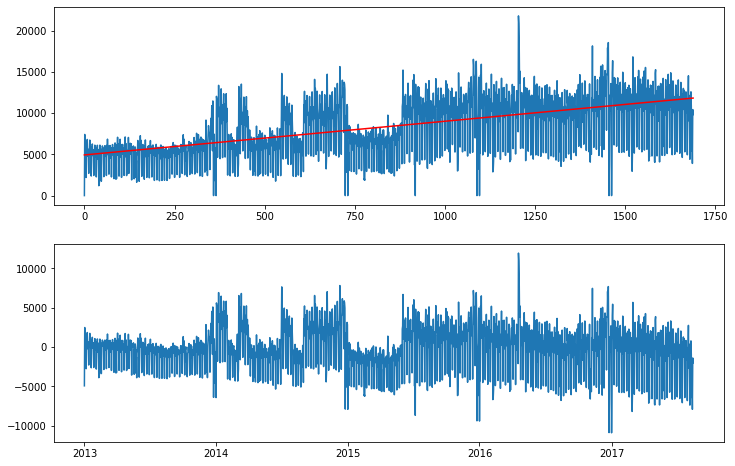

In [20]:
import scipy.signal
detrend = scipy.signal.detrend(total_sales.sales) # pass in the sales series where the trend lies

fig, ax = plt.subplots(nrows=2,figsize=(12,8))
ax[0].plot(data_points,total_sales.sales)
ax[0].plot(data_points, polynomial(data_points),c='red')
ax[1].plot(total_sales.index, detrend)
plt.show()

Each of these methods remove the trend from our data, making the time series stationary. If you are wanting to use a model that relies on the data being stationary, make sure you do this piece of data cleaning first.

## Practice

Aggregate your beverage sales data by month and apply detrending techniques:

In [1]:
#A:

## Seasonality

As well as trends, we also need to be aware of seasonality within our data. This is when we noticed a regular pattern within our data. Let's take a look at our total sales data grouped by month:

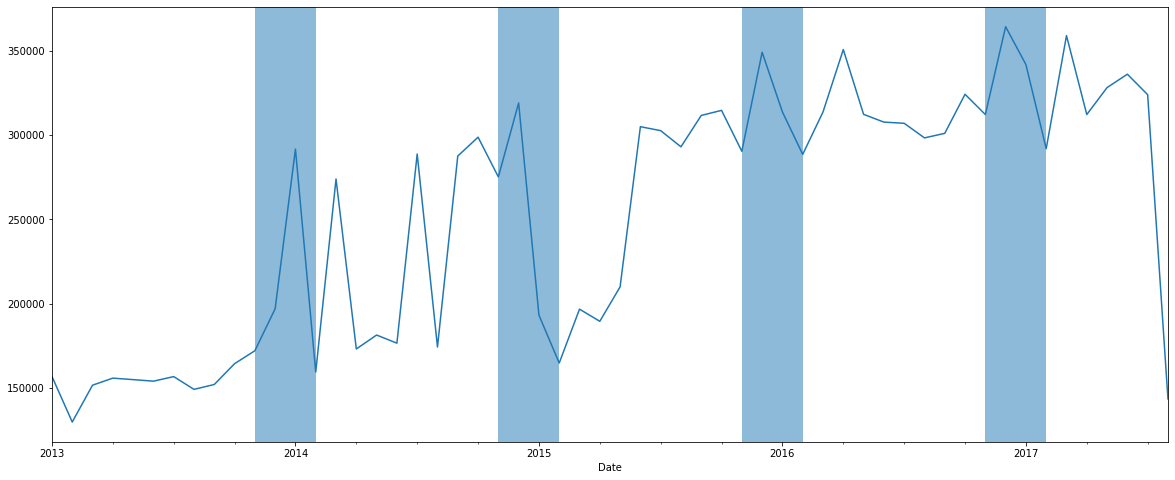

In [22]:
fig, ax = plt.subplots(figsize=(20,8))
total_sales.resample('m').sum().sales.plot(ax=ax)
ax.axvspan('11/2013','02/2014',alpha=0.5)
ax.axvspan('11/2014','02/2015',alpha=0.5)
ax.axvspan('11/2015','02/2016',alpha=0.5)
ax.axvspan('11/2016','02/2017',alpha=0.5)
plt.show()

What do you notice happening in each shaded area?

There is a spike in sales followed by an immediate drop around Christmas. This is an example of seasonality. It is something we need to be aware of in our data and should discuss when reporting back to stakeholders. Being able to spot seasonality is one thing, explaining it requires your own knowledge of the data. 

Let's look at some other factors within the data that might affect sales.

Did you notice the `onpromotion` column? This shows how many products were on promotion during that observation. Let's plot these two features against each other.

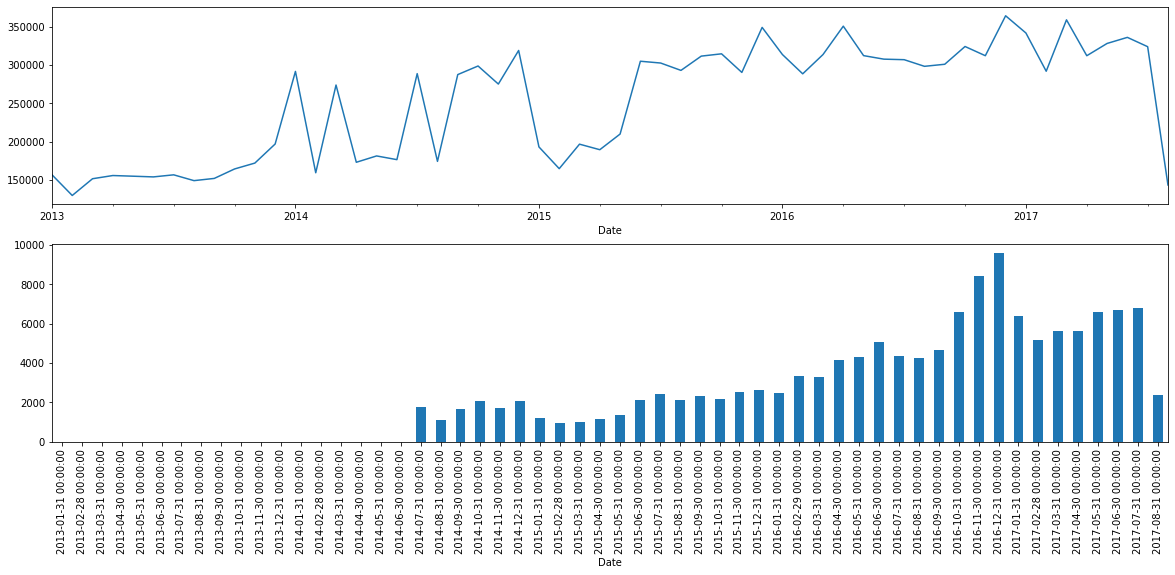

In [23]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
total_sales.resample('m').sum().sales.plot(ax=ax[0])
total_sales.resample('m').sum().onpromotion.plot(kind='bar',ax=ax[1])
plt.show()

By looking at the promotion information, we can see that the increased trend towards the back end of the data can be explained by the promotions the store put into place. The sudden drop off at the end can be explained therefore by the lack of promotions. 

Let's also look at what sales are like on different days of the week:

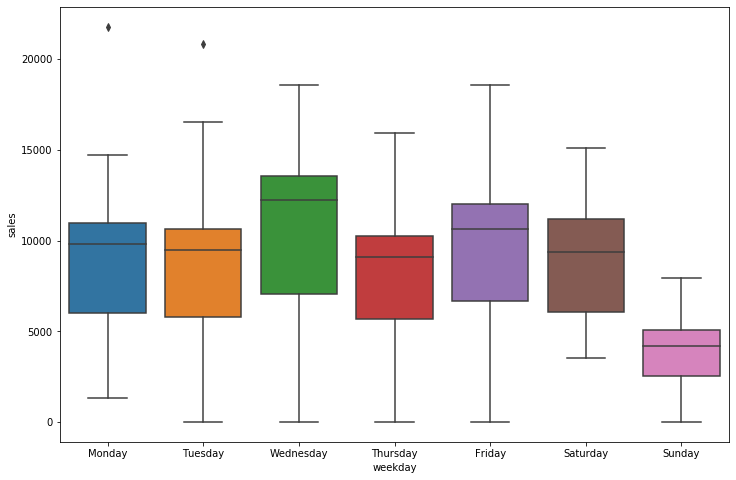

In [24]:
import seaborn as sns

total_sales['weekday']=total_sales.index.day_name()

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='weekday',y='sales',data=total_sales,ax=ax,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

What does this show us?

Wednesday seems to be the best day for sales, while Sunday is the worst. When looking at daily sales it is important to include this information to explain why some days may see a drop in sales (people tend to shop less on a Sunday).

What about holidays?

The holiday csv file lists national holidays with Ecuador, let's add these to our plot and see what the effect is.

[For reference, this store is in Quito, which is in the state Pichincha]

In [25]:
holiday=pd.read_csv('holidays_events.csv')
holiday['date']=pd.to_datetime(holiday.date)
holiday.set_index('date',inplace=True)
holiday.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Let's filter this down so it only contains information about holidays in Quito or national:

In [26]:
relevant_holidays=holiday[(holiday.type=='Holiday')&((holiday.locale=='National')|(holiday.locale_name=='Quito'))]

We are now going to join the holiday information in and plot a boxplot to check if holidays have an effect on sales:

In [27]:
total_sales=total_sales.join(relevant_holidays.type)
total_sales['type']=total_sales.type.fillna('Not Holiday')
total_sales.head()

,sales,onpromotion,difference,perc_diff,weekday,type
Date,,,,,,
2013-01-01,0.000000,0,NaN,NaN,Tuesday,Holiday
2013-01-02,7417.148000,0,7417.148000,inf,Wednesday,Not Holiday
2013-01-03,5873.244001,0,-1543.903999,-20.815332,Thursday,Not Holiday
2013-01-04,5919.879001,0,46.635000,0.794025,Friday,Not Holiday
2013-01-05,6318.785010,0,398.906009,6.738415,Saturday,Not Holiday


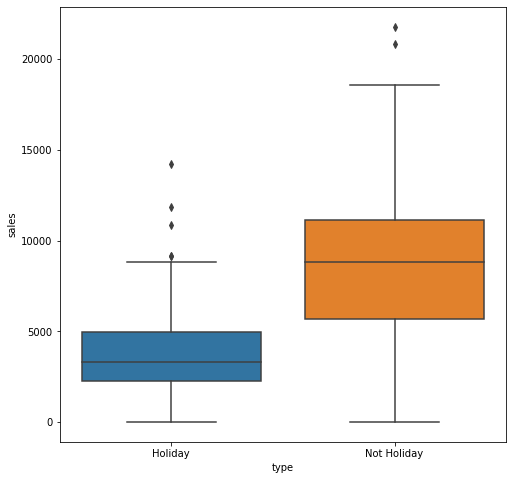

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(x='type',y='sales',data=total_sales,ax=ax)
plt.show()

The aim of this section is to introduce how we perform EDA when checking for seasonality. When examining our time series data we need to check for regular patterns and cross reference against our knowledge of the data to explain why certain patterns or trends appear.

In this dataset a lot of the seasonality can be explained by the on_promotion column, which dilutes any effect regular seasonality (i.e. time of year) might have. To give an example of regular seasonality, let's look at a dataset which contains the daily minimum temperature in Melbourne from 1981-1990.

In [29]:
daily_min_temp=pd.read_csv('daily-min-temperatures.csv')
daily_min_temp['Date']=pd.to_datetime(daily_min_temp.Date, format="%d/%m/%Y")
daily_min_temp.set_index('Date',inplace=True)
daily_min_temp.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


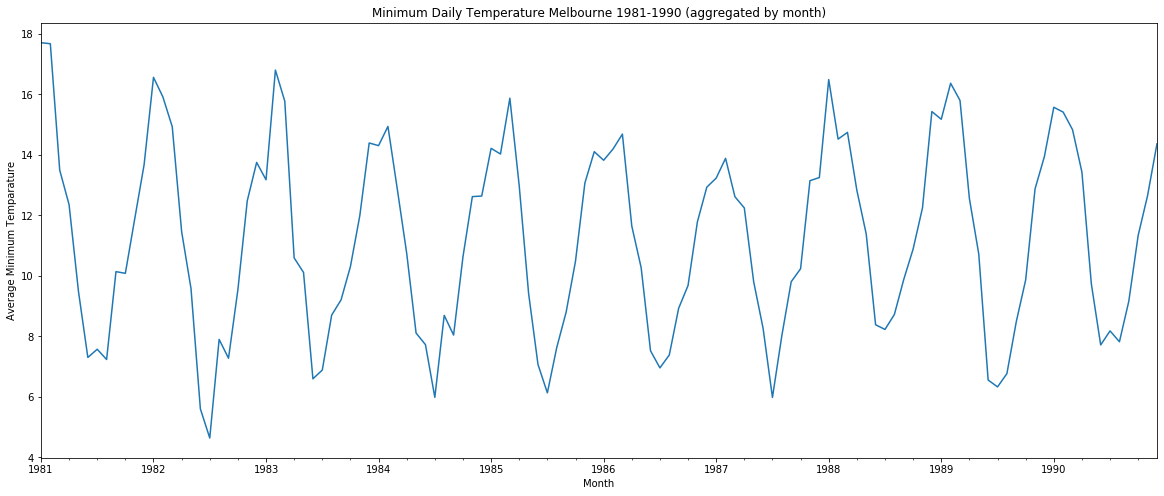

In [30]:
fig, ax = plt.subplots(figsize=(20,8))
daily_min_temp.resample('m').mean().Temp.plot(ax=ax)
ax.set_title('Minimum Daily Temperature Melbourne 1981-1990 (aggregated by month)')
ax.set_ylabel('Average Minimum Temparature')
ax.set_xlabel('Month')
plt.show()

This data shows clear seasonality, as months in similar seasons (i.e. winter) show the lower temperatures with spikes in the Australian summer months. 

These variations over the course of a year makes the data non-stationary, which we can test for:

In [31]:
# Testing at the 5% level if the temperature data is staionary:

result = adfuller(daily_min_temp.resample('m').mean().Temp)
print('p-value:' +str(result[1]))

p-value:0.33568610206497645


The p-value is greater than 5% showing that the null hypothesis is true- that the data is not stationary.

When seasonality causes the data to not be stationary we can use the techniques from earlier (rolling windows, etc) to smooth over the data and reduce the effect seasonality has on our data:

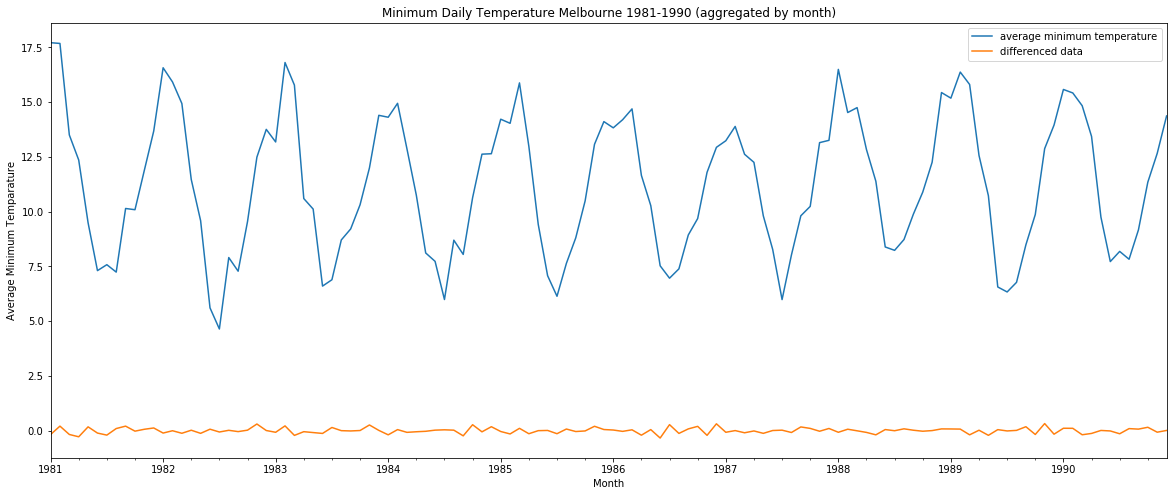

In [32]:
daily_min_temp['difference']=daily_min_temp.Temp.diff(periods = 1)

fig, ax = plt.subplots(figsize=(20,8))
daily_min_temp.resample('m').mean().Temp.plot(ax=ax, label='average minimum temperature')
daily_min_temp.resample('m').mean().difference.plot(ax=ax,label='differenced data')
ax.set_title('Minimum Daily Temperature Melbourne 1981-1990 (aggregated by month)')
ax.set_ylabel('Average Minimum Temparature')
ax.set_xlabel('Month')
plt.legend()
plt.show()

By finding the differences in average minimum temperature between consecutive observations, we can see the seasonal peaks and valleys have been removed from our data. If the forecasting model you are wanting to use requires the data to be stationary, then differencing your data is a method for removing seasonal trends.

Let's also check that the data is now stationary:

In [33]:
# Testing at the 5% level if the differenced temperature data is staionary:

result = adfuller(daily_min_temp.resample('m').mean().difference)
print('p-value:' +str(result[1]))

p-value:2.0887164574982943e-11


The p-value is less than 5% showing that the null hypothesis is to be rejected- that the data is stationary.


## Practice

In your work, what would be the most common causes of seasonality in your data? How can you check for them?

In [34]:
#A:

## Using an ACF plot to investigate trends and seasonality

Another method of investigating trends and seasonality is to plot an AutoCorrelation Function (ACF). We met this function during Activate as a way of looking at autocorrelation in our data. 

When time series data has a trend, the level of autocorrelation between observations nearby in time tend to be large and positive, as these observations will be similar in size. So the ACF of time series with strong trends will tend to have positive values that slowly decrease as the lags (difference in observation lengths) increase.

For seasonal data, the autocorrelation will be large for 'seasonal lags', for example, if there is a weekly seasonality (i.e. each day of the week consistently shows its own sales trend), then lag 7 on an ACF will be large.

Let's plot an ACF for our sales data, aggregated by month and use it to examine trend and seasonality:

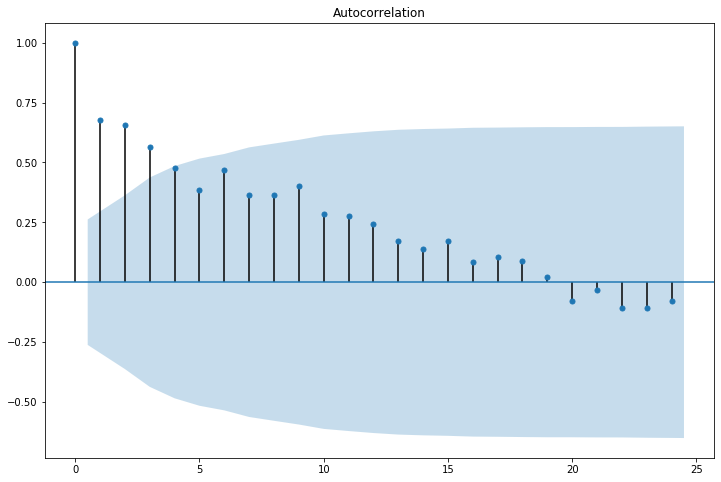

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

# plot autocorrelation for data aggregated by month (24 lags for 2 years)
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(total_sales.resample('m').sum().sales, lags=24, ax=ax) 
plt.show()

Looking at our ACF above, we can see that there is a consistent trend of large positive autocorrelations in the lower lags that decrease in size. This indicates that our monthly sales data shows a strong trend (and therefore not stationary). 

It is harder in this dataset to identify seasonality. If there was strong seasonality in the data we would expect lags 12 and 24 (data showing 12 months and 24 months apart) to be large.

Let's take a look at the ACF for the minimum daily temperatures in Melbourne for an example of strong seasonality:

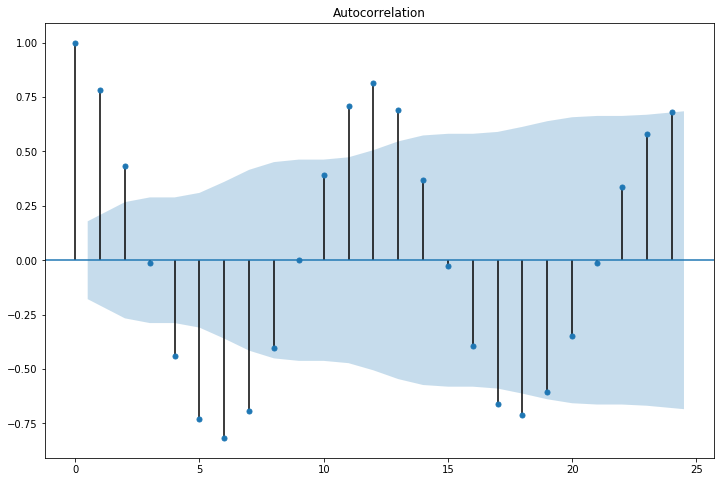

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(daily_min_temp.resample('m').mean().Temp, lags=24, ax=ax) 
plt.show()

With this plot we can see regular large autocorrelations which is highly suggestive of seasonality.

## Decomposition

We have seen in the previous sections that we can examine our data for trends and seasonality. This allows us to explain why we have observed patterns within our data (from our knowledge of the data context) as well as put in mitigations to make the data stationary. Another method within our toolkit is to use the `seasonal_decompose` function.

This function takes time series data and breaks it down into different parts, these parts being:

<ul>
    <li><b>Observed</b>- The time series data as observed </li>
    <li><b>Trend</b>- The observed trend within the data </li>
    <li><b>Seasonal</b>- The observed seasonality within the data</li>
    <li><b>Residual</b>- What is left once the trend and seasonality has been removed</li>
</ul>

Ideally, once trends and seasonality have been accounted for, the residuals should stay constant over time.

<Figure size 432x288 with 0 Axes>

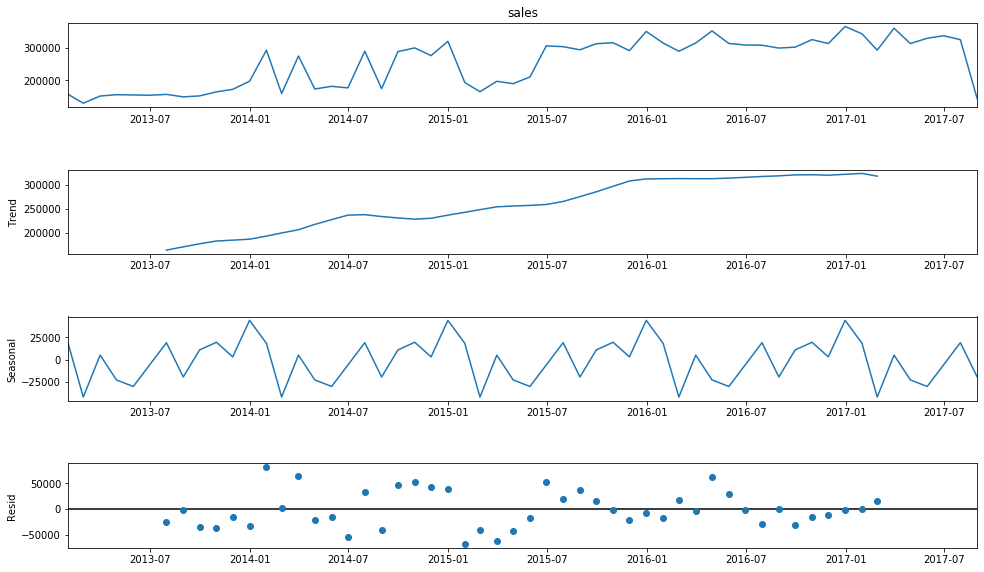

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(total_sales.resample('m').sum().sales, period=12)  

fig = plt.figure()  
fig = decompose.plot() 
fig.set_size_inches((16, 9))
plt.show()

What do the different parts of this visualisation show?

You can see clearly the trend within the data and the seasonal pattern. This leaves the residuals, which is what is left after the trend and seasonality is removed. 

If you're planning on using a time series model that relies on the data being stationary, then you can use the seasonal decompose function to extract the residuals and build the model from there (assuming the residuals are stationary).

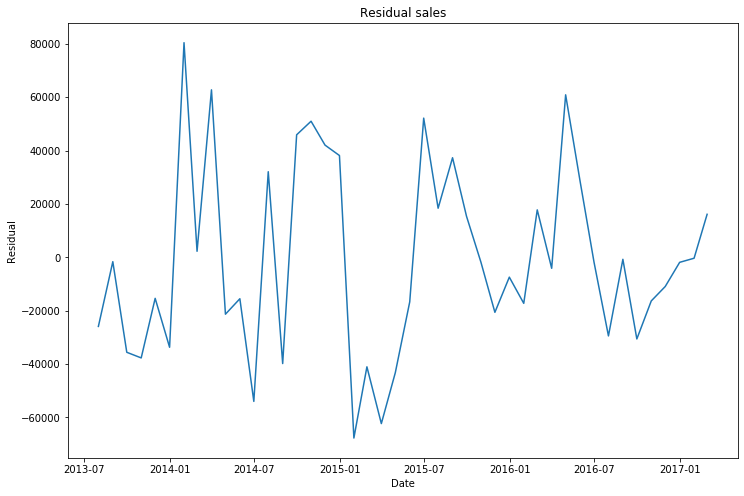

In [38]:
residuals=decompose.resid  # extract residuals from seasonal_decompose

fig, ax = plt.subplots(figsize=(12,8)) 
ax.plot(residuals.index,residuals) 
ax.set_title('Residual sales')
ax.set_ylabel('Residual')
ax.set_xlabel('Date')
plt.show()

In [39]:
# Testing at the 5% level if the residual data is staionary:

result = adfuller(residuals.dropna())
print('p-value:' +str(result[1]))

p-value:7.749471805022576e-07


With a p-value < 5% we can reject the null hypothesis that the data is not-stationary.

If a model requires your data to be stationary, then using `seasonal_decompose()` to extract the residuals is a quick and easy method for producing stationary data.

## Practice

Build a seasonal decomposition plot for your beverage sales data aggregated by month. Interpret the different parts of the visualisation.

In [2]:
#A:


## Autocorrelation

For a time series dataset to be stationary, the mean, variance and autocorrelation must not change over time. We have seen how to check for the mean over time (variance follows), but let's now look at autocorrelation. 

As a reminder from Activate, autocorrelation is a measure of how correlated observations are with those that occur later. For example, if we were to examine visitors at a them park per day we would expect a high level of correlation on equivalent days (i.e. similar numbers on a Saturday). Whereas, with data showing share prices we would expect a high level of autocorrelation on consecutive observations.

Therefore, it is acceptable if there is observed autocorrelation within our data- what makes it stationary is that it stays the same over time.

When checking autocorrelation, we need to consider lags. Lag is the difference between two observations, so for consecutive observations we would have `lag=1`. For observations a week apart, we would have `lag=7`. 

To calculate autocorrelation, we just need the `.autocorr()` function.

In [41]:
total_sales.resample('m').sum().sales.autocorr(lag=1)

0.7021318834477795

What do you think this means?

Consecutive months are highly correlated (i.e. if one month sees high sales, the next will be similar).

To save us from calculating autocorrelation for each possible combination of lags, we can use statsmodels `plot_acf` function.

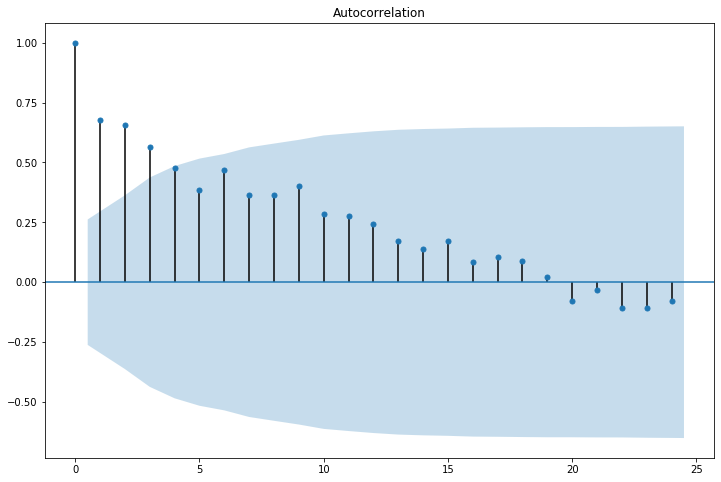

In [42]:
from statsmodels.graphics.tsaplots import plot_acf

# plot autocorrelation for data aggregated by month (24 lags for 2 years)
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(total_sales.resample('m').sum().sales, lags=24, ax=ax) 
plt.show()


Each line represents the autocorrelation at a given lag. The first one is at lag 0 (autocorrelation of an observation with itself) which will always be 1 (a data point is always fully correlated with itself).

The second line represents the autocorrelation of consecutive months, which we have seen are already highly correlated. Any points which fall outside of the blue area show lags with significant correlations. For example, if the data showed high seasonality then the lag at 12 and 24 would be high (i.e. every January having similar sales and so on). 

As we saw earlier, as the lags follow a pattern of decreasing large autocorrelations, this is indicitive of a strong trend in the data.

An issue with this approach however is that when the lag is greater than 1 then previous lags have an effect. For example, at `lag = 2` it means we are comparing January and March, February and April and so on. But what about the month in between? 

It is still having an effect.

With partial autocorrelation we can perform the same analysis, except this time it controls for the lags that fall in between (i.e. comparing January and March while ignoring February).

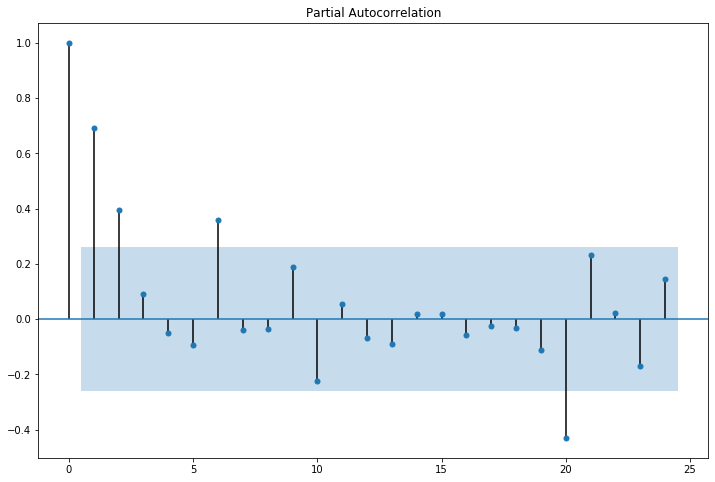

In [43]:
from statsmodels.graphics.tsaplots import plot_pacf

# plot partial autocorrelation for data aggregated by month (24 lags for 2 years)
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(total_sales.resample('m').sum().sales, lags=24,ax=ax) 
plt.show()

We interpret this plot in the same way as before, this time we can see lags 1, 2, 6 and 20 are showing significant autocorrelation. This indicates the time series data is not stationary as there is similarities between monthly sales at 6 month intervals. 

Let's see what the autocorrelation is like for this data once it has been detrended:

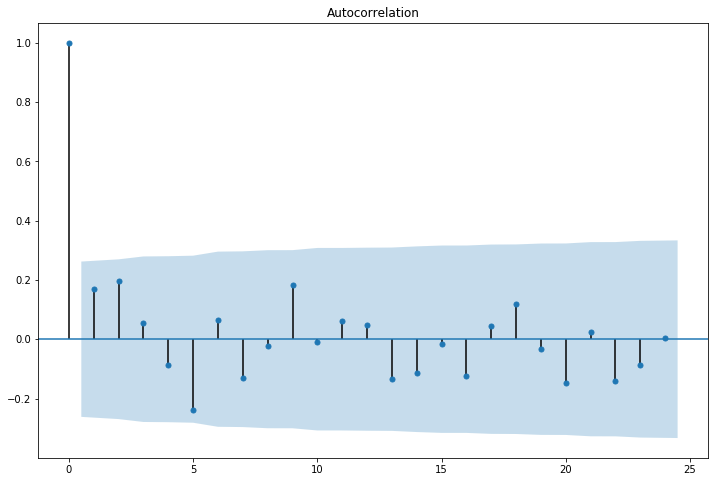

In [44]:
detrend = scipy.signal.detrend(total_sales.resample('m').sum().sales.values)
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(detrend, lags=24,ax=ax) 
plt.show()

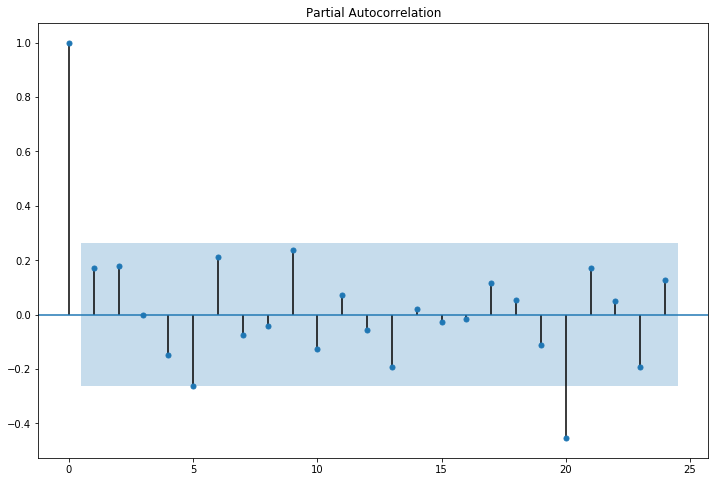

In [45]:
detrend = scipy.signal.detrend(total_sales.resample('m').sum().sales.values)
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(detrend, lags=24,ax=ax) 
plt.show()

Taking the trend out of the data removes a lot of the autocorrelation (although lag 20 is still showing a lot in the partial autocorrelation plot). This shows how detrending can help make our data more stationary.

Autocorrelation is an important measure in establishing which sort of time series model we can use. Autocorrelation measures how independent observations are, with high levels of autocorrelation showing a lack of independence. Time series data often shows autocorrelation, meaning models like linear regression would not be appropriate. Instead, we need to choose models which account for these issues (which we will see in the next workshop).

## Practice

Make autocorrelation and partial autocorrelation plots for your beverage sales data aggregated by month.

In [3]:
#A: